In [1]:
'''

This code is part of the SIPN2 project focused on improving sub-seasonal to seasonal predictions of Arctic Sea Ice. 
If you use this code for a publication or presentation, please cite the reference in the README.md on the
main page (https://github.com/NicWayand/ESIO). 

Questions or comments should be addressed to nicway@uw.edu

Copyright (c) 2018 Nic Wayand

GNU General Public License v3.0


'''

'''
Plot forecast maps with all available models.
'''

%matplotlib inline
%load_ext autoreload
%autoreload
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
from collections import OrderedDict
import itertools
import numpy as np
import timeit
import numpy.ma as ma
import pandas as pd
import struct
import os
import xarray as xr
import xesmf as xe
import glob
import datetime
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns
np.seterr(divide='ignore', invalid='ignore')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from esio import EsioData as ed
from esio import ice_plot
from esio import import_data
from esio import metrics


import dask
#dask.set_options(get=dask.threaded.get)


# General plotting settings
sns.set_style('ticks')
sns.set_context("talk", font_scale=.8, rc={"lines.linewidth": 2.5})

In [2]:
E = ed.EsioData.load()
# Directories
runType='forecast'
updateall = False

In [3]:
# Plotting Info
runType = 'forecast'
variables = ['sic']
metrics_all = {'sic':['IFD']}
updateAll = True
# Some models are terrible/have serious issues, so don't include in MME
MME_NO = ['hcmr']

In [4]:
# Target time range
valid_start = np.datetime64('2018-06-01')
valid_end = np.datetime64('2018-09-30')

In [5]:
# Define custom mod names
custom_names = {'usnavysipn':'NESM','gfdlsipn':'GFDL/NOAA','noaasipn':'NOAA CPC','uclsipn':'UCL','ukmetofficesipn':'Met Office','ecmwfsipn':'ECMWF'}

In [6]:
# Define models to plot
models_2_plot = list(E.model.keys())
models_2_plot = [x for x in models_2_plot if np.any(x not in ['piomas','MME','modcansipns_3','modcansipns_4']) ] # remove some models
models_2_plot = [x for x in models_2_plot if E.icePredicted[x]] # Only predictive models
models_2_plot

['gfdlsipn',
 'yopp',
 'ukmetofficesipn',
 'ecmwfsipn',
 'ecmwf',
 'metreofr',
 'ukmo',
 'kma',
 'ncep',
 'usnavysipn',
 'usnavyncep',
 'rasmesrl',
 'noaasipn',
 'noaasipn_ext',
 'uclsipn',
 'szapirosipn']

In [7]:
stero_grid_file = E.obs['NSIDC_0051']['grid']
obs_grid = import_data.load_grid_info(stero_grid_file, model='NSIDC')
# Ensure latitude is within bounds (-90 to 90)
# Have to do this because grid file has 90.000001
obs_grid['lat_b'] = obs_grid.lat_b.where(obs_grid.lat_b < 90, other = 90)

In [8]:
# Regridding Options
method='nearest_s2d' # ['bilinear', 'conservative', 'nearest_s2d', 'nearest_d2s', 'patch']

### Load in User submited SIP data

In [9]:
user_sip = [] # Dictionary to store user submitted (regridded) SIP data

### npssipn (RASM)

In [10]:
# cmod = 'RASM'
# sip_f = '/home/disk/sipn/upload/npssipn/forecast/Forecast/RASM_Sep2018_Junreportdata.nc'
# # Open
# ds_user = xr.open_dataset(sip_f)
# #ds_user.SIP_ID.plot()
# # Regrid/format to sipn
# ds_user.rename({'lat':'nj', 'long':'ni','longitude':'lon','latitude':'lat'}, inplace=True);
# ds_user.set_coords(['lat','lon'], inplace=True)
# # Select SIP
# da_in = ds_user.SIP_ID
# mask = ds_user.Grid_Area.notnull()
# da_in = da_in.where(mask)



# # Calculate regridding matrix
# regridder = xe.Regridder(da_in, obs_grid, method, periodic=False)
# # Regrid 
# da_out = regridder(da_in)
# # Remove weight file
# regridder.clean_weight_file() 
# # da_in.plot()
# # plt.figure()
# # da_out.plot()

# # Store in dict of user submited SIP
# da_out.coords['model'] = cmod
# user_sip.append(da_out)

### cansips (Mod CanSIPS)

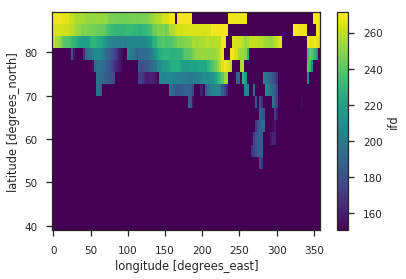

In [11]:
cmod = 'Mod CanSIPS'
sip_f = '/home/disk/sipn/upload/ecsipn/Mod-CanSIPS-CanCM4-i2018m06_IFD.nc'
ds_user = xr.open_dataset(sip_f, drop_variables='time')
ds_user.rename({'longitude':'lon','latitude':'lat'}, inplace=True);
ds_user.set_coords(['lat','lon'], inplace=True)
da_in = ds_user.ifd.isel(time=0).mean(dim='ensemble')
# Set never melts to first valeus (to be consistent with how sipn does it)
da_in = da_in.where(da_in<273, other=da_in.min().values)
da_in.plot()

In [12]:
# Calculate regridding matrix
regridder = xe.Regridder(da_in, obs_grid, method, periodic=False)
# Regrid 
da_out = regridder(da_in)
# Remove weight file
regridder.clean_weight_file() 
# da_in.plot()
# plt.figure()
# da_out.plot()
# Store in dict of user submited SIP
da_out.coords['model'] = cmod
user_sip.append(da_out)

Create weight file: nearest_s2d_18x128_304x448.nc
Remove file nearest_s2d_18x128_304x448.nc


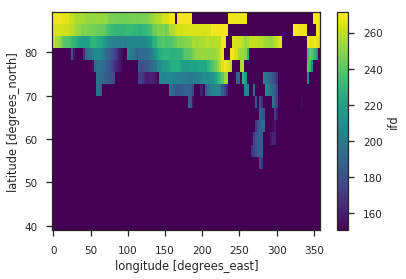

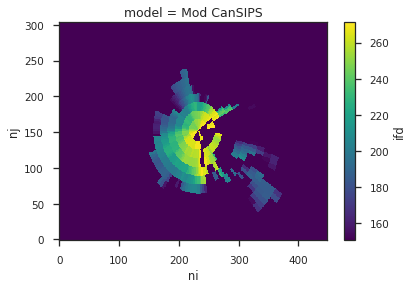

In [13]:
da_in.plot()
plt.figure()
da_out.plot()

### nrlsipn (NESM)

In [14]:
cmod = 'NESM'
sip_f = '/home/disk/sipn/nicway/data/model/usnavysipn/forecast/metrics_from_nrl/NESM_Sep2018_Maydata_IFD_common.nc'
ds_user = xr.open_dataset(sip_f)
ds_user.rename({'Longitude':'lon','Latitude':'lat'}, inplace=True);
# Select SIP
da_in = ds_user.IFD.isel(MT=0)
da_in 

<xarray.DataArray 'IFD' (lat: 31, lon: 360)>
array([[121., 121., 121., ..., 121., 121., 121.],
       [121., 121., 121., ..., 121., 121., 121.],
       [121., 121., 121., ..., 121., 121., 121.],
       ...,
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]], dtype=float32)
Coordinates:
    MT       datetime64[ns] 2018-09-15
    Date     float64 ...
  * lat      (lat) float32 60.0 61.0 62.0 63.0 64.0 65.0 66.0 67.0 68.0 69.0 ...
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 ...
Attributes:
    long_name:    Ice-free date
    units:        Julian Day
    valid_range:  [121.      243.00095]

Create weight file: nearest_s2d_31x360_304x448_peri.nc
Remove file nearest_s2d_31x360_304x448_peri.nc
Not adding User submited NESM here, Joe wanted us to use our own calculated one


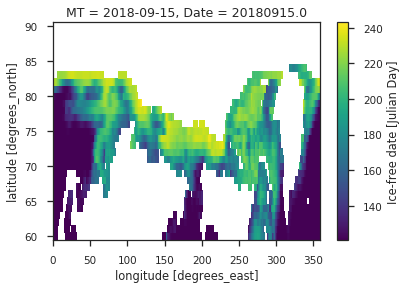

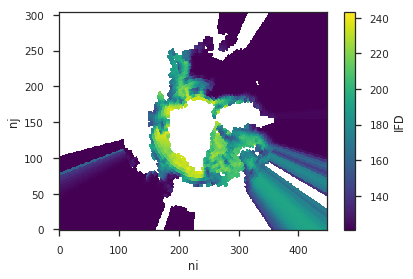

In [15]:
# Calculate regridding matrix
regridder = xe.Regridder(da_in, obs_grid, method, periodic=True)
# Regrid 
da_out = regridder(da_in)
# Remove weight file
regridder.clean_weight_file() 
da_in.plot()
plt.figure()
da_out.plot()
# Store in dict of user submited SIP
da_out.coords['model'] = cmod
print("Not adding User submited NESM here, Joe wanted us to use our own calculated one")
#user_sip.append(da_out)

In [16]:
usr_IFD = xr.concat(user_sip, dim='model')
usr_IFD = usr_IFD.rename({'nj':'x', 'ni':'y'})
usr_IFD.name = 'IFD'
usr_IFD

<xarray.DataArray 'IFD' (model: 1, x: 304, y: 448)>
array([[[151., 151., ..., 151., 151.],
        [151., 151., ..., 151., 151.],
        ...,
        [151., 151., ..., 151., 151.],
        [151., 151., ..., 151., 151.]]])
Coordinates:
    lon      (x, y) float64 168.3 168.4 168.5 168.7 168.8 168.9 169.0 169.1 ...
    lat      (x, y) float64 31.1 31.25 31.4 31.55 31.69 31.84 31.99 32.13 ...
  * model    (model) <U11 'Mod CanSIPS'
Dimensions without coordinates: x, y
Attributes:
    regrid_method:  nearest_s2d

In [17]:
# Target year and month
cyear = '2018'
cmonth = 'June'

In [18]:
for cvar in variables:
    
    # Define fig dir and make if doesn't exist
    fig_dir = os.path.join(E.fig_dir, 'model', 'SIO_Reports', cyear, cmonth)
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)
       
    # Loop through variable of interest + any metrics (i.e. SIP) based on that
    for metric in metrics_all[cvar]:



        MME_list = []      
    

        # For each model
        for (i, cmod) in enumerate(models_2_plot):
            print(cmod)

            # Load in Model
            model_forecast = os.path.join(E.model[cmod][runType]['sipn_nc'], '*.nc') 

            # Check we have files 
            files = glob.glob(model_forecast)
            if not files:
                #print("Skipping model", cmod, "no forecast files found.")
                continue # Skip this model

            ds_model = xr.open_mfdataset(model_forecast, 
                        chunks={'init_time': 1, 'nj': 304, 'ni': 448}, 
                                         concat_dim='init_time', autoclose=True, parallel=True)
            ds_model.rename({'nj':'x', 'ni':'y'}, inplace=True)

            # Restrictions for calculating IFD
            
            # 1) Must be Daily or less
            c_dt = (ds_model.fore_time[1]-ds_model.fore_time[0]).values.astype('timedelta64[D]').astype('int')
            if c_dt > 1:
                print("fore_time timestep greater than 1 day, skipping.")
                continue
            
            
            # Select var of interest (if available)
            if cvar in ds_model.variables:
#                     print('found ',cvar)
                ds_model = ds_model[cvar]
            else:
                print('cvar not found.')
                continue
                  
            # Get most recent init_time
            if cmod == 'usnavysipn': # Uses a lagged ensemble... so grab all inits and make them ensembles
                print(cmod, " uses a lagged ensemble, so using average")
                temp_init = ds_model.init_time[0].values
                ds_model = ds_model.isel(ensemble=0).rename({'init_time':'ensemble'})
                ds_model.coords['ensemble'] = np.arange(0,ds_model.ensemble.size)
                ds_model.coords['init_time'] = temp_init
            else:
                ds_model = ds_model.isel(init_time=ds_model.init_time.size-1)      
                  
            # Get Valid time
            ds_model = import_data.get_valid_time(ds_model.expand_dims('init_time'))
                           
            # Check if we have any valid times in range of target dates
            ds_model = ds_model.where((ds_model.valid_time>=valid_start) & (ds_model.valid_time<=valid_end), drop=True) 
            if ds_model.fore_time.size == 0:
                print("no fore_time found for target period.")
                continue
                
            # 2) Must have a forecast that goes until end of sept.
            last_f = ds_model.valid_time.max()
            if last_f < valid_end - np.timedelta64(20,'D'): # allow 5 days wiggle room
                print('last Valid time', last_f.values, ' was not within 20 days of target end ', valid_end)
                continue
                
            # Averave SIC over ensembles
            ds_model = ds_model.mean(dim='ensemble')
                
            # Calculate IFD
            DOY_first_vt = [x.timetuple().tm_yday for x in pd.to_datetime([ds_model.valid_time.min().values])]
            ds_ifd = metrics.calc_IFD_10day(ds_model, sic_threshold=0.5, DOY_s=DOY_first_vt[0], time_dim='fore_time', 
                                            Nday=10)

            # Build MME
            ds_idf = ds_ifd.isel(init_time=0).drop('init_time')
#             if 'ensemble' in ds_ifd.coords:
#                 ds_model = ds_model.drop('ensemble')
            if cmod not in MME_NO: # Exclude some models (bad) from MME
                ds_ifd.coords['model'] = cmod
                MME_list.append(ds_ifd)
                print('Added ', cmod, ' to MME.')


# Concat over all models
ds_MME = xr.concat(MME_list, dim='model')
ds_MME.name = 'IFD'

gfdlsipn


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in less
  return func(*args2)


Added  gfdlsipn  to MME.
yopp
last Valid time 2018-07-21T12:00:00.000000000  was not within 20 days of target end  2018-09-30
ukmetofficesipn


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in less
  return func(*args2)


Added  ukmetofficesipn  to MME.
ecmwfsipn


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in less
  return func(*args2)


Added  ecmwfsipn  to MME.
ecmwf
last Valid time 2018-08-03T00:00:00.000000000  was not within 20 days of target end  2018-09-30
metreofr
last Valid time 2018-07-16T00:00:00.000000000  was not within 20 days of target end  2018-09-30
ukmo
last Valid time 2018-08-17T00:00:00.000000000  was not within 20 days of target end  2018-09-30
kma
last Valid time 2018-08-17T00:00:00.000000000  was not within 20 days of target end  2018-09-30
ncep
last Valid time 2018-08-01T00:00:00.000000000  was not within 20 days of target end  2018-09-30
usnavysipn
usnavysipn  uses a lagged ensemble, so using average


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in less
  return func(*args2)


Added  usnavysipn  to MME.
usnavyncep
last Valid time 2018-08-10T00:00:00.000000000  was not within 20 days of target end  2018-09-30
rasmesrl
last Valid time 2018-07-19T00:00:00.000000000  was not within 20 days of target end  2018-09-30
noaasipn
fore_time timestep greater than 1 day, skipping.
noaasipn_ext
uclsipn


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in less
  return func(*args2)


Added  uclsipn  to MME.
szapirosipn


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in less
  return func(*args2)


Added  szapirosipn  to MME.


In [19]:
# Take mean
ds_MME = ds_MME.mean(dim='init_time')
ds_MME = ds_MME.drop(['time'])

In [20]:
# Merge user SIP with SPIN SIP
ds_IFD_All = xr.concat([ds_MME, usr_IFD], dim='model')

In [21]:
# Load into memory
ds_IFD_All.load();

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [22]:
# Get mean and std of all models
ds_MME_avg = ds_IFD_All.mean(dim='model')
ds_MME_std = ds_IFD_All.std(dim='model')

In [23]:
c_vmin = [x.timetuple().tm_yday for x in [pd.datetime(2018,6,1)]][0]
c_vmax = [x.timetuple().tm_yday for x in [pd.datetime(2018,10,1)]][0]

In [24]:
# Get dates for plot
last_IFD = pd.to_datetime((np.datetime64('2018-01-01') + np.timedelta64(int(c_vmax),'D')))
date_str = pd.to_datetime(datetime.datetime(2018, 6, 1)).strftime('%Y-%m-%d')

In [25]:
# Get monthly ticks
import calendar
DOY_months = [x.timetuple().tm_yday for x in pd.date_range(date_str,'2018-10-30', freq='MS')]
DOY_labels = [calendar.month_abbr[mn]+' 1' for mn in np.arange(6,last_IFD.month+1)]
assert len(DOY_months)==len(DOY_labels)

In [26]:
# Masks land in cansips (no mask)
ds_IFD_All.loc[dict(model='Mod CanSIPS')] = ds_IFD_All.sel(model='Mod CanSIPS').where(ds_IFD_All.isel(model=0).notnull())

gfdlsipn
ukmetofficesipn
ecmwfsipn
usnavysipn
uclsipn
szapirosipn
Mod CanSIPS
saved  /home/disk/sipn/nicway/public_html/sipn/figures/model/SIO_Reports/2018/June/panArctic_IFD_forecast_2018_June.png


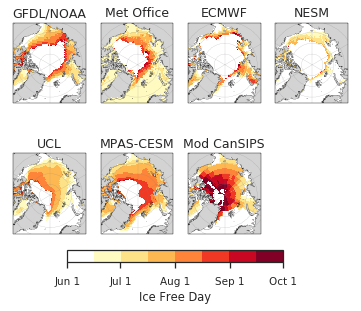

In [27]:
# Set up plotting info
if cvar=='sic':
    if metric=='mean':
        cmap_c = matplotlib.colors.ListedColormap(sns.color_palette("Blues_r", 10))
        cmap_c.set_bad(color = 'lightgrey')
        c_label = 'Sea Ice Concentration (-)'
        c_vmin = 0
        c_vmax = 1
    elif metric=='SIP':
        cmap_c = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white","orange","red","#990000"])
        cmap_c.set_bad(color = 'lightgrey')
        c_label = 'Sea Ice Probability (-)'
        c_vmin = 0
        c_vmax = 1
    elif metric=='anomaly':
        cmap_c = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","white","blue"])
        cmap_c.set_bad(color = 'lightgrey')
        c_label = 'SIC Anomaly to 1980-2010 Mean'
        c_vmin = -1
        c_vmax = 1
    elif metric=='IFD':
        cfile = '/home/disk/sipn/nicway/python/ESIO/notebooks/color_redhues.mat'
        import scipy.io
        matfile = scipy.io.loadmat(cfile)
        redhues = matfile['redhues']
        cmap_c = matplotlib.colors.LinearSegmentedColormap.from_list('redhues', redhues, N=8)
        cmap_c.set_bad(color = 'lightgrey')
        c_label = 'Ice Free Day'


elif cvar=='hi':
    if metric=='mean':
        cmap_c = matplotlib.colors.ListedColormap(sns.color_palette("Reds_r", 10))
        cmap_c.set_bad(color = 'lightgrey')
        c_label = 'Sea Ice Thickness (m)'
        c_vmin = 0
        c_vmax = None
else:
    raise ValueError("cvar not found.") 


    
def add_subplot_title(cmod, custom_names, E, ax=None):
    if cmod in custom_names:
        ax.set_title(custom_names[cmod])
    elif cmod in E.model.keys():
        ax.set_title(E.model[cmod]['model_label'])
    else:
        ax.set_title(cmod)

# New Plot
central_extent = [-3850000*0.6, 3725000*0.6, -5325000*0.45, 5850000*0.45] # (x0, x1, y0, y1
(f, axes) = ice_plot.multi_polar_axis(ncols=4, nrows=2, Nplots=8, extent=central_extent, central_longitude=0)

for (i, cmod) in enumerate(ds_IFD_All.model.values):
    print(cmod)
    # Plot
    add_subplot_title(cmod, custom_names, E, ax=axes[i])
    p = ds_IFD_All.sel(model=cmod).plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                          transform=ccrs.PlateCarree(),
                          add_colorbar=False,
                          cmap=cmap_c,
                          vmin=c_vmin, vmax=c_vmax)
    add_subplot_title(cmod, custom_names, E, ax=axes[i])

# Make pretty
f.subplots_adjust(bottom=0.05)
cbar_ax = f.add_axes([0.25, 0.001, .5, 0.04]) #  [left, bottom, width, height] w
cbar = f.colorbar(p, cax=cbar_ax, label=c_label, orientation='horizontal')
cbar.set_ticks(DOY_months)
cbar.set_ticklabels(DOY_labels)

# Save to file
f_out = os.path.join(fig_dir,'panArctic_'+metric+'_'+runType+'_'+cyear+'_'+cmonth+'.png')
f.savefig(f_out,bbox_inches='tight', dpi=200)
print("saved ", f_out)

gfdlsipn
ukmetofficesipn
ecmwfsipn
usnavysipn
uclsipn
szapirosipn
Mod CanSIPS
saved  /home/disk/sipn/nicway/public_html/sipn/figures/model/SIO_Reports/2018/June/panArctic_IFD_forecast_2018_June_plus_std.png


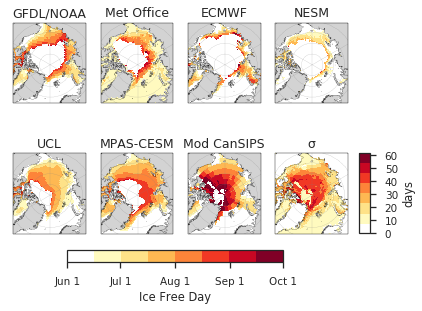

In [29]:
# Set up plotting info
if cvar=='sic':
    if metric=='mean':
        cmap_c = matplotlib.colors.ListedColormap(sns.color_palette("Blues_r", 10))
        cmap_c.set_bad(color = 'lightgrey')
        c_label = 'Sea Ice Concentration (-)'
        c_vmin = 0
        c_vmax = 1
    elif metric=='SIP':
        cmap_c = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white","orange","red","#990000"])
        #cmap_c = plt.get_cmap('jet') 
        cmap_c.set_bad(color = 'lightgrey')
        c_label = 'Sea Ice Probability (-)'
        c_vmin = 0
        c_vmax = 1
    elif metric=='anomaly':
#                         cmap_c = matplotlib.colors.ListedColormap(sns.color_palette("coolwarm", 9))
        cmap_c = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","white","blue"])
        cmap_c.set_bad(color = 'lightgrey')
        c_label = 'SIC Anomaly to 1980-2010 Mean'
        c_vmin = -1
        c_vmax = 1
    elif metric=='IFD':
#         cmap_c = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white","orange","red","#990000"], N=8)
#         cmap_c.set_bad(color = 'lightgrey')
        
        cfile = '/home/disk/sipn/nicway/python/ESIO/notebooks/color_redhues.mat'
        import scipy.io
        matfile = scipy.io.loadmat(cfile)
        redhues = matfile['redhues']
        cmap_c = matplotlib.colors.LinearSegmentedColormap.from_list('redhues', redhues, N=8)
        cmap_c.set_bad(color = 'lightgrey')
        
        cmap_std = matplotlib.colors.LinearSegmentedColormap.from_list('redhues', redhues, N=8)
        cmap_std.set_bad(color = 'lightgrey')
        
        c_label = 'Ice Free Day'


elif cvar=='hi':
    if metric=='mean':
        cmap_c = matplotlib.colors.ListedColormap(sns.color_palette("Reds_r", 10))
        cmap_c.set_bad(color = 'lightgrey')
        c_label = 'Sea Ice Thickness (m)'
        c_vmin = 0
        c_vmax = None
else:
    raise ValueError("cvar not found.") 


    
def add_subplot_title(cmod, custom_names, E, ax=None):
    if cmod in custom_names:
        ax.set_title(custom_names[cmod])
    elif cmod in E.model.keys():
        ax.set_title(E.model[cmod]['model_label'])
    else:
        ax.set_title(cmod)

# New Plot
central_extent = [-3850000*0.6, 3725000*0.6, -5325000*0.45, 5850000*0.45] # (x0, x1, y0, y1
(f, axes) = ice_plot.multi_polar_axis(ncols=4, nrows=2, Nplots=9, extent=central_extent, central_longitude=0)

for (i, cmod) in enumerate(ds_IFD_All.model.values):
    print(cmod)
    # Plot
    add_subplot_title(cmod, custom_names, E, ax=axes[i])
    p = ds_IFD_All.sel(model=cmod).plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                          transform=ccrs.PlateCarree(),
                          add_colorbar=False,
                          cmap=cmap_c,
                          vmin=c_vmin, vmax=c_vmax)
    add_subplot_title(cmod, custom_names, E, ax=axes[i])

# MME Standard deviation
i = i + 1


pstd = ds_MME_std.plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                                  transform=ccrs.PlateCarree(),
                                  add_colorbar=False, 
                                  cmap=cmap_std,vmin=ds_MME_std.min().values, vmax=ds_MME_std.max().values)
axes[i].set_title('σ')
    

# Make pretty
f.subplots_adjust(bottom=0.05)
cbar_ax = f.add_axes([0.25, 0.001, .5, 0.04]) #  [left, bottom, width, height] w
cbar = f.colorbar(p, cax=cbar_ax, label=c_label, orientation='horizontal')
cbar.set_ticks(DOY_months)
cbar.set_ticklabels(DOY_labels)

#f.subplots_adjust(right=0.05)
cbar_ax_2 = f.add_axes([0.925, 0.1, .025, .28]) #  [left, bottom, width, height] w
cbar2 = f.colorbar(pstd, cax=cbar_ax_2, label='days', orientation='vertical')
# cbar.set_ticks(DOY_months)
# cbar.set_ticklabels(DOY_labels)

# Save to file
f_out = os.path.join(fig_dir,'panArctic_'+metric+'_'+runType+'_'+cyear+'_'+cmonth+'_plus_std.png')
f.savefig(f_out,bbox_inches='tight', dpi=200)
print("saved ", f_out)